# Salmonella Serovar multi-class classification

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Preferred seaborn settings:
sns.set_style('darkgrid')
sns.set_palette('deep')

## 1.1 Loading data and EDA

In [2]:
profile_data = pd.read_csv('../data/prepared_data/six_classes_nutrient_profile_data.csv', index_col=0)
profile_data.head()

,serotype,c_butyrate_(n-c4:0)_(O2+),c_decanoate_(n-c10:0)_(O2+),c_ethanol_(O2+),c_sucrose_(O2+),c_ferrioxamine_e_fe_(O2+),c_phenethylamine_(O2+),c_ornithine_(O2+),c_adenine_(O2+),n_4-aminobutanoate_(O2+),...,c_phenylacetaldehyde_(O2-),n_4-amino-4-deoxy-l-arabinose_modified_core_oligosaccharide_lipid_a_(O2-),p_kdo(2)-lipid_(a)_(O2-),c_amp_(O2-),n_salmochelin-s2-fe-iii_exchange(O2-),c_core_oligosaccharide_lipid_a_4(O2-),n_cmp_(O2-),c_d-xylose_(O2-),n_d-glucosamine_6-phosphate_(O2-),c_udp-n-acetyl-d-galactosamine_(O2-)
genome_accession,,,,,,,,,,,,,,,,,,,,,
CP015923,Newport,0.0,0.48745,0.418011,0.0,0.0,0.0,0.607634,0.0,0.809491,...,0.0,0.0,0.0,0.274616,0.0,0.0,0.288371,0.127108,0.427014,0.098308
CP015924,Newport,0.0,0.48745,0.418011,0.0,0.0,0.0,0.607634,0.0,0.809491,...,0.0,0.0,0.0,0.274616,0.0,0.0,0.288371,0.127108,0.427014,0.098308
CP010283,Newport,0.0,0.48745,0.418011,0.0,0.0,0.0,0.607634,0.0,0.809491,...,0.0,0.0,0.0,0.274616,0.0,0.0,0.288371,0.127108,0.427014,0.098308
CP010281,Newport,0.0,0.48745,0.418011,0.0,0.0,0.0,0.607634,0.0,0.809491,...,0.0,0.0,0.0,0.274616,0.0,0.0,0.288371,0.127108,0.427014,0.098308
CP010282,Newport,0.0,0.48745,0.418011,0.0,0.0,0.0,0.607634,0.0,0.809491,...,0.0,0.0,0.0,0.274616,0.0,0.0,0.288371,0.127108,0.427014,0.098308


In [3]:
profile_data.shape

(315, 1211)

#### Overview of data:

* genome_accession: Index of data, corresponds to the ID of the genomic sequence for the given strain. It can be for the NCBI database accession (e.g. CP015923) or for the BV-BRC db (909946.3)

* serotype: This correponds to the target variable that I want to predict. 

* The rest of the columns correponds to the features of the data and are represented in the following way:

    Prefix: Type of source.

    **'c_'** : Carbon source.
  
    **'n_'** : Nitrogen source.
  
    **'p_'** : Phosphorus source.
  
    **'s_'** : Sulfur source.

    Suffix: Growth condition.

    **'(O2+)'** : Fluxes for the given source on aerobic conditions.
  
    **'(O2-)'** : Fluxes for the given source on anaerobic conditions.

* The numeric values correspond to metabolic flux of the given feature.

### 1.1 Examine target variable

In [4]:
profile_data.serotype.value_counts()

serotype
Enteritidis    159
Typhimurium     48
Paratyphi A     48
Heidelberg      26
Newport         19
Anatum          15
Name: count, dtype: int64

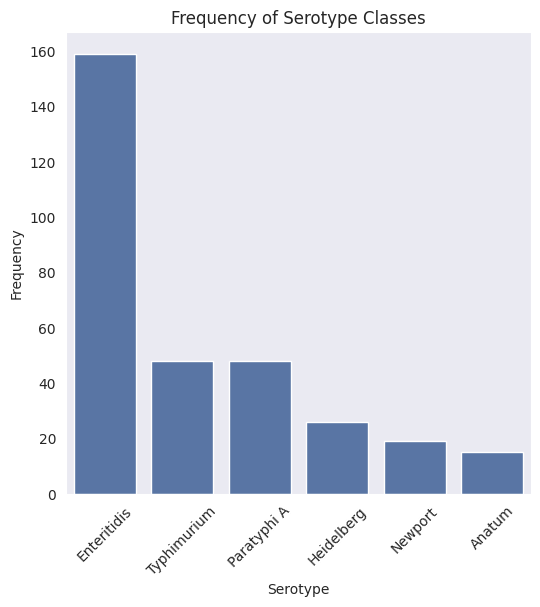

In [5]:
target_distribution = profile_data['serotype'].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(x=target_distribution.index, y=target_distribution.values, )

plt.title('Frequency of Serotype Classes')
plt.xlabel('Serotype')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')

### 1.2 Examine features

In [6]:
profile_data.describe()

,c_butyrate_(n-c4:0)_(O2+),c_decanoate_(n-c10:0)_(O2+),c_ethanol_(O2+),c_sucrose_(O2+),c_ferrioxamine_e_fe_(O2+),c_phenethylamine_(O2+),c_ornithine_(O2+),c_adenine_(O2+),n_4-aminobutanoate_(O2+),p_imp_(O2+),...,c_phenylacetaldehyde_(O2-),n_4-amino-4-deoxy-l-arabinose_modified_core_oligosaccharide_lipid_a_(O2-),p_kdo(2)-lipid_(a)_(O2-),c_amp_(O2-),n_salmochelin-s2-fe-iii_exchange(O2-),c_core_oligosaccharide_lipid_a_4(O2-),n_cmp_(O2-),c_d-xylose_(O2-),n_d-glucosamine_6-phosphate_(O2-),c_udp-n-acetyl-d-galactosamine_(O2-)
count,3.150000e+02,315.000000,315.000000,3.150000e+02,3.150000e+02,3.150000e+02,315.000000,315.000000,315.000000,315.000000,...,3.150000e+02,3.150000e+02,3.150000e+02,315.000000,3.150000e+02,315.000000,315.000000,315.000000,315.000000,315.000000
mean,-9.516197e-18,0.480231,0.411805,1.253671e-15,2.819614e-18,-9.163746e-18,0.598752,0.000227,0.797827,1.177908,...,-2.592283e-16,4.315331e-17,2.370238e-17,0.273601,-3.216122e-18,0.000002,0.286143,0.126809,0.424242,0.095950
std,4.289220e-16,0.059680,0.050757,2.147423e-14,1.633560e-16,2.495037e-16,0.073994,0.003642,0.096613,0.129699,...,4.600845e-15,7.507541e-16,4.024857e-16,0.024257,7.724476e-17,0.000037,0.023958,0.013079,0.034143,0.018698
min,-6.661338e-15,0.000000,0.000000,0.000000e+00,-1.554312e-15,-4.218847e-15,0.000000,0.000000,0.000000,0.000000,...,-8.165690e-14,0.000000e+00,-3.677614e-16,0.000000,-1.332268e-15,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.487240,0.417504,0.000000e+00,0.000000e+00,0.000000e+00,0.607608,0.000000,0.809491,1.194922,...,0.000000e+00,0.000000e+00,0.000000e+00,0.274616,0.000000e+00,0.000000,0.288371,0.127108,0.427014,0.098308
50%,0.000000e+00,0.487450,0.418011,0.000000e+00,0.000000e+00,0.000000e+00,0.607634,0.000000,0.809491,1.195404,...,0.000000e+00,0.000000e+00,0.000000e+00,0.274616,0.000000e+00,0.000000,0.288371,0.127108,0.427014,0.098308
75%,0.000000e+00,0.487450,0.418011,0.000000e+00,0.000000e+00,0.000000e+00,0.607634,0.000000,0.809491,1.195404,...,0.000000e+00,0.000000e+00,0.000000e+00,0.274616,0.000000e+00,0.000000,0.288371,0.127108,0.427014,0.098308
max,3.663736e-15,0.495810,0.426828,3.809175e-13,2.442491e-15,1.332268e-15,0.617208,0.064252,0.819252,1.877534,...,0.000000e+00,1.332268e-14,7.091550e-15,0.458938,3.191891e-16,0.000652,0.291845,0.272202,0.431883,0.251855


Since the data is very wide and contains a lot of features. I'll transform the data into tidy format and extract the information encoded in the column names as specified in the data overview.

In [7]:
def determine_source(nutrient):
    if nutrient.startswith('c_'):
        return 'carbon'
    elif nutrient.startswith('n_'):
        return 'nitrogen'
    elif nutrient.startswith('p_'):
        return 'phosphorous'
    elif nutrient.startswith('s_'):
        return 'sulfur'

In [8]:
def determine_condition(nutrient):
    if nutrient.endswith('(O2+)'):
        return 'aerobic'
    elif nutrient.endswith('(O2-)'):
        return 'anaerobic'

In [9]:
def prepare_tidy_data(df):
    
    tidy_df = pd.melt(df.reset_index(), ['genome_accession', 'serotype'], var_name='nutrient', value_name='flux')
    tidy_df['source_type'] = tidy_df.nutrient.apply(determine_source)
    tidy_df['condition'] = tidy_df.nutrient.apply(determine_condition)
    
    return tidy_df

In [10]:
# Get tidy format
tidy_profile_data = pd.melt(profile_data.reset_index(), ['genome_accession','serotype'], var_name='nutrient',value_name='flux')

# Extract feature information
tidy_profile_data['source_type'] = tidy_profile_data.nutrient.apply(determine_source)
tidy_profile_data['condition'] = tidy_profile_data.nutrient.apply(determine_condition)

tidy_profile_data

,genome_accession,serotype,nutrient,flux,source_type,condition
0,CP015923,Newport,c_butyrate_(n-c4:0)_(O2+),0.000000,carbon,aerobic
1,CP015924,Newport,c_butyrate_(n-c4:0)_(O2+),0.000000,carbon,aerobic
2,CP010283,Newport,c_butyrate_(n-c4:0)_(O2+),0.000000,carbon,aerobic
3,CP010281,Newport,c_butyrate_(n-c4:0)_(O2+),0.000000,carbon,aerobic
4,CP010282,Newport,c_butyrate_(n-c4:0)_(O2+),0.000000,carbon,aerobic
...,...,...,...,...,...,...
381145,90371.991,Typhimurium,c_udp-n-acetyl-d-galactosamine_(O2-),0.098308,carbon,anaerobic
381146,909946.3,Typhimurium,c_udp-n-acetyl-d-galactosamine_(O2-),0.098308,carbon,anaerobic
381147,990282.4,Typhimurium,c_udp-n-acetyl-d-galactosamine_(O2-),0.098308,carbon,anaerobic
381148,99287.12,Typhimurium,c_udp-n-acetyl-d-galactosamine_(O2-),0.098308,carbon,anaerobic


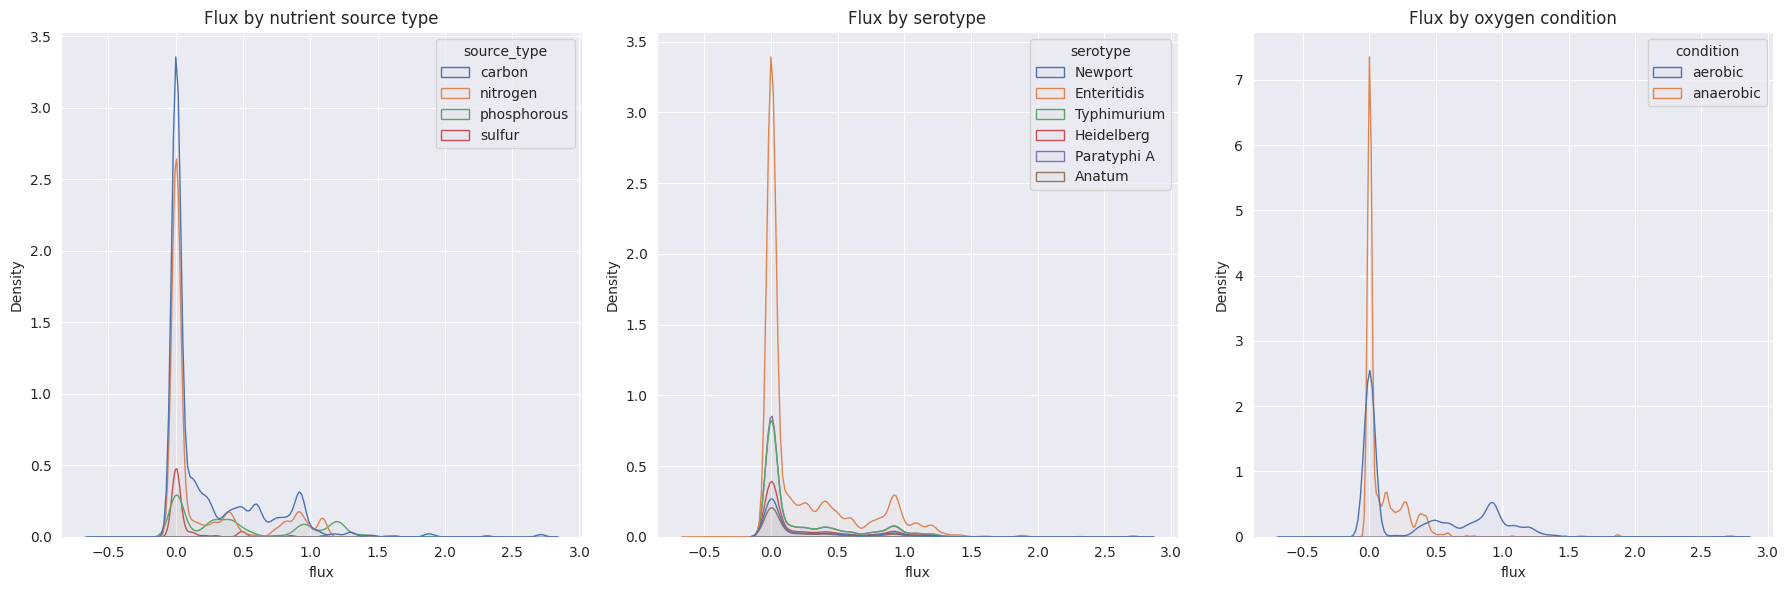

In [11]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title('Flux by nutrient source type')
sns.kdeplot(tidy_profile_data, x='flux', hue='source_type', fill=True, alpha=0.03)

plt.subplot(1,3,2)
plt.title('Flux by serotype')
sns.kdeplot(tidy_profile_data, x = 'flux', hue='serotype', fill=True, alpha=0.03)

plt.subplot(1,3,3)
plt.title('Flux by oxygen condition')
sns.kdeplot(tidy_profile_data, x ='flux', hue='condition', fill=True, alpha=0.03)

plt.tight_layout()

The data is positively skewed, with a very high density centered around 0, indicating that there is a high number of nutrients with 0 flux

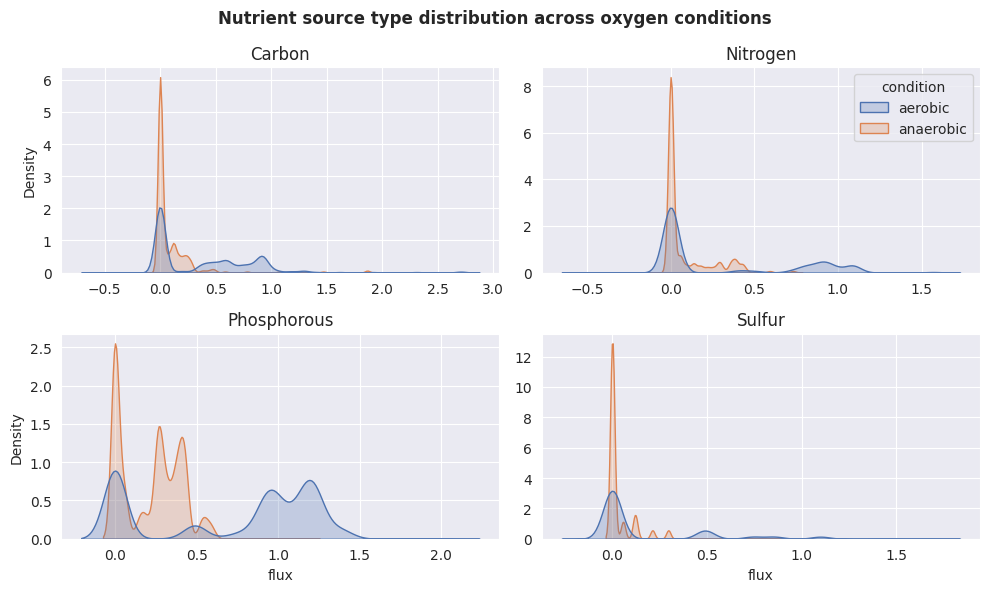

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.title('Carbon')
sns.kdeplot(tidy_profile_data[tidy_profile_data.source_type == 'carbon'], x='flux', hue='condition', fill=True,legend=False)
plt.xlabel('')

plt.subplot(2,2,2)
plt.title('Nitrogen')
sns.kdeplot(tidy_profile_data[tidy_profile_data.source_type == 'nitrogen'], x='flux', hue='condition', fill=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
plt.title('Phosphorous')
sns.kdeplot(tidy_profile_data[tidy_profile_data.source_type == 'phosphorous'], x='flux', hue='condition', fill=True,legend=False)


plt.subplot(2,2,4)
plt.title('Sulfur')
sns.kdeplot(tidy_profile_data[tidy_profile_data.source_type == 'sulfur'], x='flux', hue='condition', fill=True,legend=False)
plt.ylabel('')

plt.suptitle('Nutrient source type distribution across oxygen conditions', fontweight='bold')
plt.tight_layout()

### 1.3 Splitting data and examine feature selection on training data

I'll do an initial split to examine the impact of filtering and selecting features on the distribution of the training data:

In [13]:
df_full_train, df_test = train_test_split(profile_data, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [14]:
y_full_train = df_full_train.serotype.values
y_train = df_train.serotype.values
y_val = df_val.serotype.values
y_test = df_test.serotype.values

In [15]:
numerical = df_train.loc[:, df_train.columns != 'serotype'].columns.to_list()

In [16]:
vt = VarianceThreshold(0.01)
variable_reactions = vt.fit_transform(df_train[numerical])
features_mask = vt.get_support()

In [17]:
reduced_df = df_train[numerical].loc[:,features_mask]

In [18]:
filtered_df_target = pd.concat([reduced_df, df_train['serotype']], axis=1)

In [19]:
tidy_filtered = prepare_tidy_data(filtered_df_target)

<Axes: xlabel='flux', ylabel='Density'>

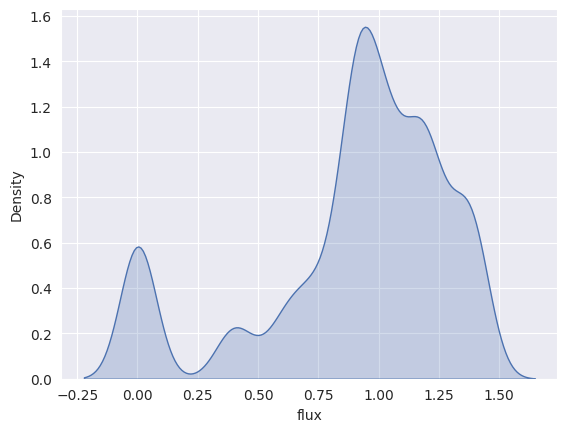

In [20]:
sns.kdeplot(tidy_filtered, x = 'flux', fill=True)

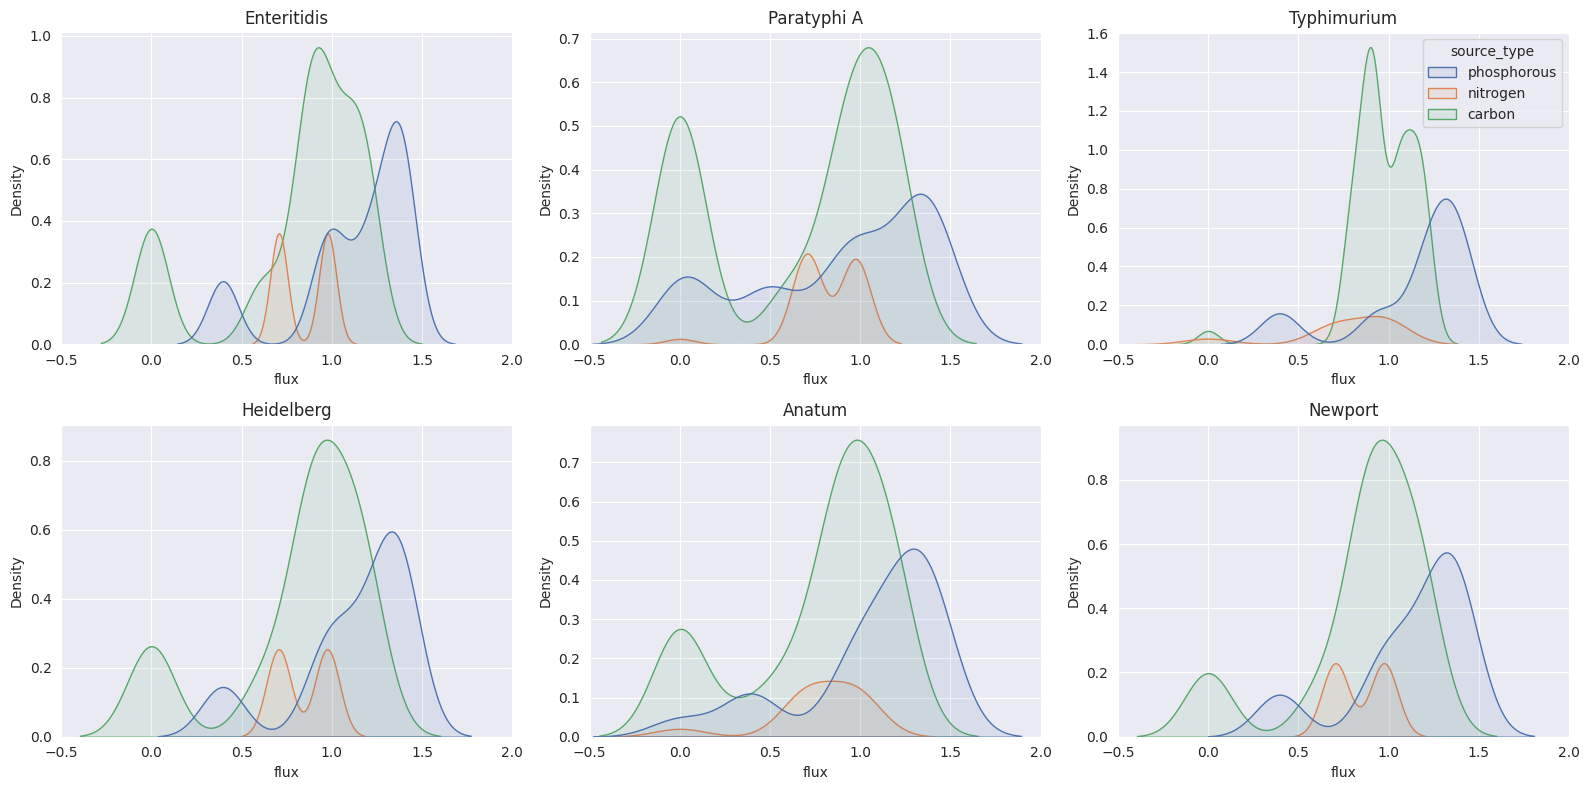

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Enteritidis')
sns.kdeplot(tidy_filtered[tidy_filtered.serotype == 'Enteritidis'], x='flux', hue='source_type', fill=True ,alpha=0.1, legend=False)
plt.xlim(-0.5,2)

plt.subplot(2,3,2)
plt.title('Paratyphi A')
sns.kdeplot(tidy_filtered[tidy_filtered.serotype == 'Paratyphi A'], x='flux', hue='source_type',fill=True ,alpha=0.1, legend=False)
plt.xlim(-0.5,2)

plt.subplot(2,3,3)
plt.title('Typhimurium')
sns.kdeplot(tidy_filtered[tidy_filtered.serotype == 'Typhimurium'], x='flux', hue='source_type', fill=True ,alpha=0.1)
plt.xlim(-0.5,2)

plt.subplot(2,3,4)
plt.title('Heidelberg')
sns.kdeplot(tidy_filtered[tidy_filtered.serotype == 'Heidelberg'], x='flux', hue='source_type', fill=True ,alpha=0.1, legend=False)
plt.xlim(-0.5,2)

plt.subplot(2,3,5)
plt.title('Anatum')
sns.kdeplot(tidy_filtered[tidy_filtered.serotype == 'Anatum'], x='flux', hue='source_type', fill=True ,alpha=0.1, legend=False)
plt.xlim(-0.5,2)

plt.subplot(2,3,6)
plt.title('Newport')
sns.kdeplot(tidy_filtered[tidy_filtered.serotype == 'Newport'], x='flux', hue='source_type', fill=True ,alpha=0.1, legend=False)
plt.xlim(-0.5,2)

plt.tight_layout()

## 2. Model training

### 2.1 Splitting data and encoding target variable

In [22]:
df_full_train, df_test = train_test_split(profile_data, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [23]:
y_full_train = df_full_train.serotype.values
y_train = df_train.serotype.values
y_val = df_val.serotype.values
y_test = df_test.serotype.values

In [24]:
del df_full_train['serotype']

del df_train['serotype']

del df_val['serotype']

del df_test['serotype']

#### Encoding target variable on training dataset

In [25]:
label_encoder = LabelEncoder()
y_full_train_encoded = label_encoder.fit_transform(y_full_train)

In [26]:
y_test_encoded = label_encoder.transform(y_test)

### 2.2 Baseline model

In [27]:
# Train baseline
lr = LogisticRegression(max_iter=1000,random_state=11)
lr.fit(df_full_train, y_full_train_encoded)

# Make predictions
y_pred_baseline = lr.predict(df_test)
y_pred_overfit_baseline = lr.predict(df_full_train)

print(f"Accuracy baseline: {accuracy_score(y_test_encoded, y_pred_baseline)}")
print(f"Accuracy overfit: {accuracy_score(y_full_train_encoded, y_pred_overfit_baseline)}")

Accuracy baseline: 0.8412698412698413
Accuracy overfit: 0.8134920634920635


<Axes: >

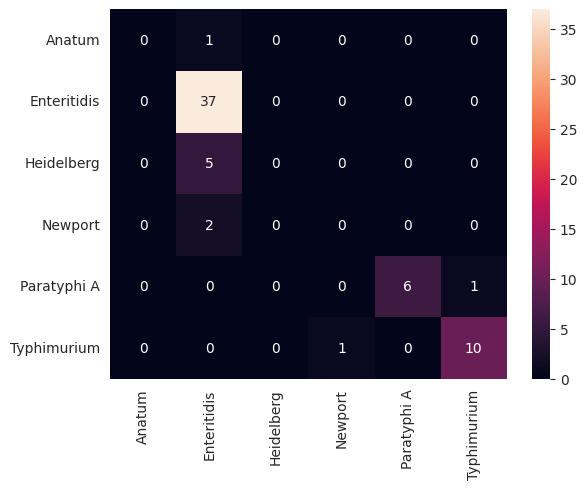

In [28]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred_baseline)
class_names = label_encoder.classes_

sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)

### 2.3 Decision tree

In [29]:
from sklearn.metrics import f1_score, make_scorer

In [30]:
f1_scorer = make_scorer(f1_score, average='weighted')

In [31]:
dt = DecisionTreeClassifier(random_state=11)
dt.fit(df_full_train, y_full_train_encoded)

y_pred_dt_base = dt.predict(df_test)
y_pred_dt_overfit = dt.predict(df_full_train)

print(accuracy_score(y_test_encoded, y_pred_dt_base))
print(accuracy_score(y_full_train_encoded, y_pred_dt_overfit))

0.9206349206349206
0.9325396825396826


In [32]:
dt = DecisionTreeClassifier(random_state=11)
dt.fit(df_full_train, y_full_train_encoded)

f1_scorer(dt, df_test, y_test_encoded), f1_scorer(dt, df_full_train, y_full_train_encoded)

(0.9096459096459096, 0.9289158903342668)

<Axes: >

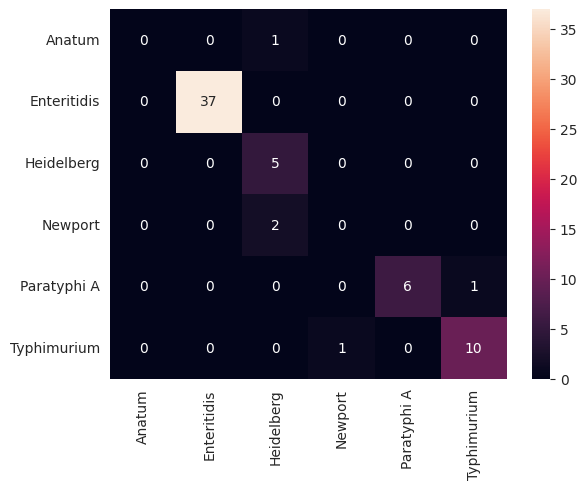

In [33]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred_dt_base)
class_names = label_encoder.classes_

sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)

#### Hyperparameter tuning

In [34]:
def grid_search_variance_selection(
    X_train: pd.DataFrame, 
    y_train_encoded: np.ndarray, 
    classifier, 
    param_grid,
    cv_folds: int = 5
):
    pipeline = Pipeline([
        ('feature_selection', VarianceThreshold(threshold=0.1)),
        ('classifier', classifier)
    ])

    f1_scorer = make_scorer(f1_score, average='weighted')
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring=f1_scorer, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train_encoded)
    
    return grid_search

In [35]:
param_grid = {
    'feature_selection__threshold': [0.1, 0.03, 0.01, 0.001],
    'classifier__criterion': ['gini','entropy','log_loss'],
    'classifier__max_depth': [1, 2, 3, 4, 6 ,8],
    'classifier__min_samples_leaf': [1,2,3,4]
}

In [36]:
grid_search = grid_search_variance_selection(df_full_train, y_full_train_encoded,
                                             classifier=DecisionTreeClassifier(random_state=11),
                                             param_grid=param_grid
                                            )

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [37]:
grid_search.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 1,
 'feature_selection__threshold': 0.01}

In [38]:
grid_search.best_score_

0.8622957678999201

In [39]:
y_pred = grid_search.predict(df_test)

<Axes: >

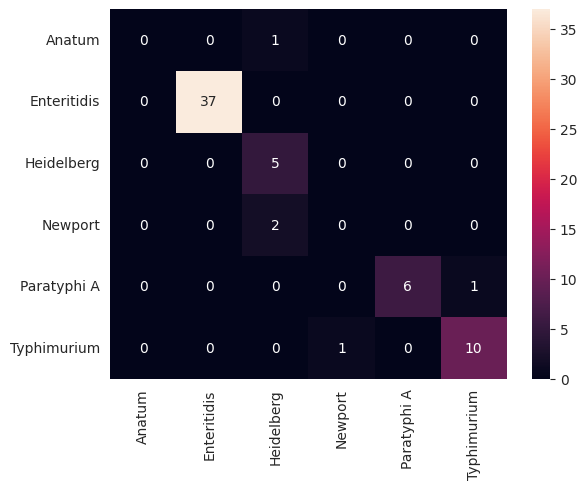

In [40]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)

In [41]:
import dtreeviz

In [42]:
features_mask_dt = grid_search.best_estimator_['feature_selection'].get_support()
selected_features = df_full_train.loc[:,features_mask_dt].columns.to_list()

In [43]:
dt_best = grid_search.best_estimator_['classifier']

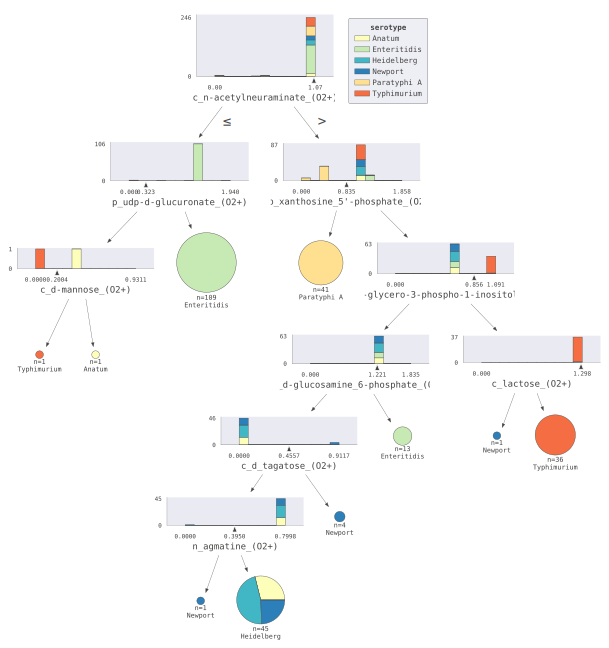

In [44]:
viz_model = dtreeviz.model(dt_best,
                           X_train=df_full_train[selected_features], y_train=y_full_train_encoded,
                           feature_names=selected_features,
                           target_name='serotype',
                           class_names=label_encoder.classes_)
v= viz_model.view(fontname='monospace')
v

### 2.4 Random Forest

In [45]:
rf = RandomForestClassifier(random_state=11)
rf.fit(df_full_train, y_full_train_encoded)

rf_base_pred = rf.predict(df_test)
overfit_rf_base = rf.predict(df_full_train)

print(f"Accuracy test: {accuracy_score(y_test_encoded, rf_base_pred)} ")
print(f"Accuracy train: {accuracy_score(y_full_train_encoded, overfit_rf_base)}")
print("")
print(f"F1 weigthed test: {f1_scorer(rf, df_test, y_test_encoded)}")
print(f"F1 weigthed train: {f1_scorer(rf, df_full_train, y_full_train_encoded)}")

Accuracy test: 0.9047619047619048 
Accuracy train: 0.9285714285714286

F1 weigthed test: 0.8927449270306413
F1 weigthed train: 0.9234295248479013


<Axes: >

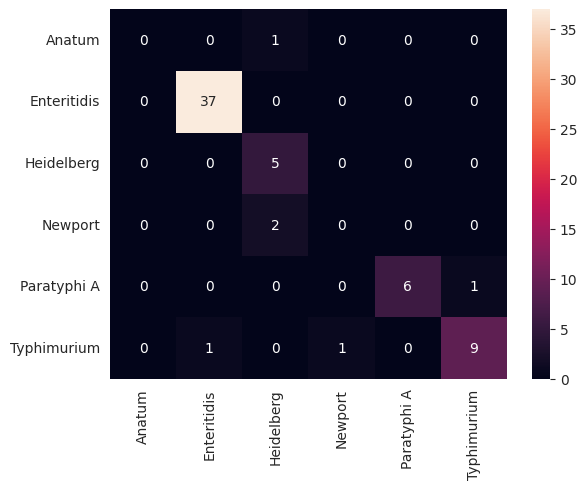

In [46]:
conf_matrix = confusion_matrix(y_test_encoded, rf_base_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)

#### Hyperparameter tuning and cross-validation

In [47]:
param_grid = {
    'feature_selection__threshold': [0.1, 0.03, 0.01, 0.001],
    'classifier__n_estimators': [10, 50, 100, 200], 
    'classifier__max_depth': [None, 1, 2, 3, 4],
    'classifier__min_samples_leaf': [1,2,3],
}

In [48]:
grid_results_rf = grid_search_variance_selection(X_train = df_full_train,
                                                y_train_encoded = y_full_train_encoded,
                                                classifier= RandomForestClassifier(random_state=11, class_weight='balanced_subsample'),
                                                param_grid=param_grid
                                               )

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [49]:
grid_results_rf.best_score_

0.8604134149587436

In [50]:
grid_results_rf.best_params_

{'classifier__max_depth': None,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 50,
 'feature_selection__threshold': 0.03}

In [51]:
best_estimator_rf = grid_results_rf.best_estimator_

In [52]:
best_estimator_rf

Pipeline(steps=[('feature_selection', VarianceThreshold(threshold=0.03)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=50, random_state=11))])

In [54]:
y_pred = grid_results_rf.predict(df_test)
y_pred_train = grid_results_rf.predict(df_full_train)

print(f"Accuracy test: {accuracy_score(y_test_encoded, y_pred)} ")
print(f"Accuracy train: {accuracy_score(y_full_train_encoded, y_pred_train)}")
print("")
print(f"F1 weigthed test: {f1_scorer(best_estimator_rf, df_test, y_test_encoded)}")
print(f"F1 weigthed train: {f1_scorer(best_estimator_rf, df_full_train, y_full_train_encoded)}")

Accuracy test: 0.9206349206349206 
Accuracy train: 0.9047619047619048

F1 weigthed test: 0.9096459096459096
F1 weigthed train: 0.8900919450919451


<Axes: >

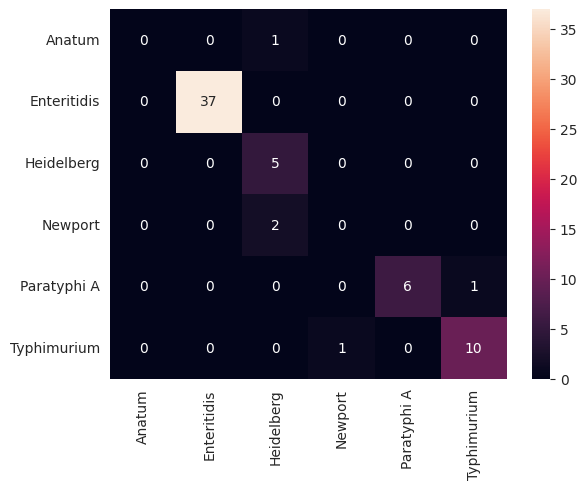

In [55]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)

In [56]:
print(classification_report(y_test_encoded, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           0        nan      0.00      0.00         1
           1       1.00      1.00      1.00        37
           2       0.62      1.00      0.77         5
           3       0.00      0.00      0.00         2
           4       1.00      0.86      0.92         7
           5       0.91      0.91      0.91        11

    accuracy                           0.92        63
   macro avg       0.71      0.63      0.60        63
weighted avg       0.92      0.92      0.91        63



### Conclusion

Overall, the models have trouble detecting the minority classes (Anatum and Newport). This could be caused by the very small dataset that is available. Possible solutions include:

- Collecting more genomic data from NCBI and BV-BRC databases for salmonella strains classified as these two serovars. Build strain-specific models for them and get all features by profiling their nutrient utilization capabilities

- Use class balance techniques like SMOTE. However, I would recommend checking the overall abundance of these two serovars in updated databases and consult with domain experts to verify if the abundance of these serovars is comparable to the other ones or if they represent a rare type.